# IADS final exam 2023

## Theoretic part

## Question 1 (5pts).
Imagine training a model that considers multiple street segments and aims to predict the traffic based on the known characteristics of the street segments. Some of the street segments from the training sample have the observed amount of traffic specified for them, others do not. How would you classify this problem from the Machine Learning perspective?

A. Supervised learning;

B. Unsupervised learning;

C. Semi-supervised learning;

D. Reinforcement learning.

Explain your choice: 

I choose C. 

Because in this case, the model is trained on a dataset containing labeled and unlabeled examples. The semi-supervised learning model uses labeled data to learn patterns and generalizations, and also uses unlabeled data to improve the understanding of the overall data distribution, which is consistent with the characteristics of the data in the question.

## Question 2 (5pts).
Regression $y\sim a_1 x_1 + a_2 x_2 +a_3 x_3$ have p-value of $0.03$ for $x_1$, $0.3$ for $x_2$ and $0.15$ for $x_3$. Does it mean that (select all that apply): 

A. Impact of $x_3$ is twice stronger than impact of $x_2$.

B. Regressors $x_2$ and $x_3$ are irrelevant.

C. One could reject the null-hypothesis $a_j=0$ only for $j=1$ but not for $j=2$ and $j=3$ at 95% singificance level.

D. The estimated value of $a_1$ is statistically significant.

E. 95%-confidence indervals for $a_2$ and $a_3$ should contain zero.

My Choices: C, D, E are True.  Option B may also be applicable under certain circumstances but the description is not rigorous actually.

## Question 3 (5pts).
Which of the following statements (select all that apply) are true about overfitting problem for linear regression:

A. Overfitting problem could be detected by R-squared if the in-sample R-squared
is very low.

B. Overfitting problem often happens when we do not have enough features but a big
number of observations.

C. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is very low.

D. Overfitting problem could happen when we have many noisy features but a
small number of observations.

E. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is considerably lower compared to in-sample R-squared.

Explain how do you understand the concept of overfitting in general and in the context of your answer.

My Choices: D, E are True. Option C may correct，the description of it is not comprehensive enough.

Explaination: Overfitting often captures some noise and error values in the training set. The fitting effect is very good in the training set, but the fitting effect of the model is not good for other new data sets. Option C: If the model fits well in the training set and validation set, R2 is relatively high, but in the test set or other data sets, R2 is very low, then it is likely that the model is overfitting, but if R2 is also relatively low in the training set, then there may be other problems rather than overfitting. Option D: When the data scale is relatively small and contains many noisy features, the regression model may not be able to capture the correct pattern of the other data, and it may only fit well to the initial training set which is small and has a lot of noise. This is also overfitting. Option E: It is similar to the explanation of Option C. When the in-sample R2 is relatively high but the out-sample R2 is relatively low, then it is likely to be overfitting.

## Question 4 (5pts).
You trained the regression model with 100 regressors and 1000 observations in the training and another 1000 in the test sample. You found that in-sample R2 over the training sample is 70\% and the out-of-sample R2 over the test sample only - 30\%.

a) Do you think there is any problem and how would you characterize it? Can adding more regressors (if you have them) help the model?

A: I think there is a problem, maybe overfitting. We can't add more regressors because more regressors will exacerbate the overfitting problem.

b) Which approaches you may use to solve the problem?

A: Use regularization techniques like Ridge or Lasso regression;
Reduce the number of regressors, remove some the irrelevent; 
Use Cross-Validation.

c) Would you expect the in-sample R2 to increase or decrease after that applying suggested approaches from step b)? What about the out-of-sample (test) R2?

A: in-sample R2 will decrease and out-of-sample R2 will increase after applying suggested approaches.

In [1]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Traffic Modeling for Real-Time Autonomous Vehicle Solutions in LGA

Transportation network models are essential to transportation operations and planning. A simple yet well-designed linear model can provide us insights into the traffic demand. We are going to model the outgoing traffic around LGA, one of the busiest transportation hubs in NYC.
In this test, you'll be asked to:
* Find possible correlations from observations
* Incorporate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

We will be importing the dataset `LGAVehicleByHour.csv`,`LGAFlightArrival` providing FHV and taxi ridership and arrivals at the airport aggregated on the hourly basis:
* `vehicle_count`: Number of FHV (For Hire Vehicle) and taxi departing from LGA. This is our target variable.
* `arrivals`: Number of incoming domestic flights arriving LGA, which is assumed to provide a basis for future FHV and taxi demand

In [2]:
# import and curate the dataset
TaxiRidership = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAVehicleByHour.csv")
FlightArrival = pd.read_csv("https://raw.githubusercontent.com/CUSP2020PUI/Data/master/LGAFlightArrival.csv")

In [3]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count
0,1,2018-01-01 00:00,0.0
1,2,2018-01-01 00:00,0.0
2,3,2018-01-01 00:00,0.0
3,4,2018-01-01 00:00,0.0
4,5,2018-01-01 00:00,0.0


In [4]:
FlightArrival.head()

,Date,arrivals
0,18/1/1 0:00,3
1,18/1/1 1:00,0
2,18/1/1 2:00,1
3,18/1/1 3:00,0
4,18/1/1 4:00,0


In [5]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [6]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [7]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [8]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

## Task 1. Spatial visualization (10pts)

### Q1. Spatial distribution of total ridership from LGA on each day of week. Using colormap 'RdBu_r', bonus on if you plot 7 plots on the same colormap scale (+3pts).
Note: Figure's readability will also be considered when grading. Please always include necessary parts such as labels and legends.

In [9]:
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')

In [10]:
Geodata = taxi.merge(TaxiRidership,left_on='location_i',right_on='DOLocationID')

In [11]:
Geodata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,DOLocationID,Date,vehicle_count,DOW,Hour,day
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,2018-01-01 00:00:00,0.0,0,0,0
1,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,2018-01-01 01:00:00,0.0,0,1,0
2,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,2018-01-01 02:00:00,0.0,0,2,0
3,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,2018-01-01 03:00:00,0.0,0,3,0
4,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",1,2018-01-01 04:00:00,1.0,0,4,0


In [12]:
vcdf = Geodata.groupby(by=['DOLocationID','DOW'], as_index=False).sum()[['DOLocationID','DOW', 'vehicle_count']]

In [13]:
Geodf = taxi.merge(vcdf,left_on='location_i',right_on='DOLocationID')

In [14]:
Geodf.vehicle_count.max()

48129.0

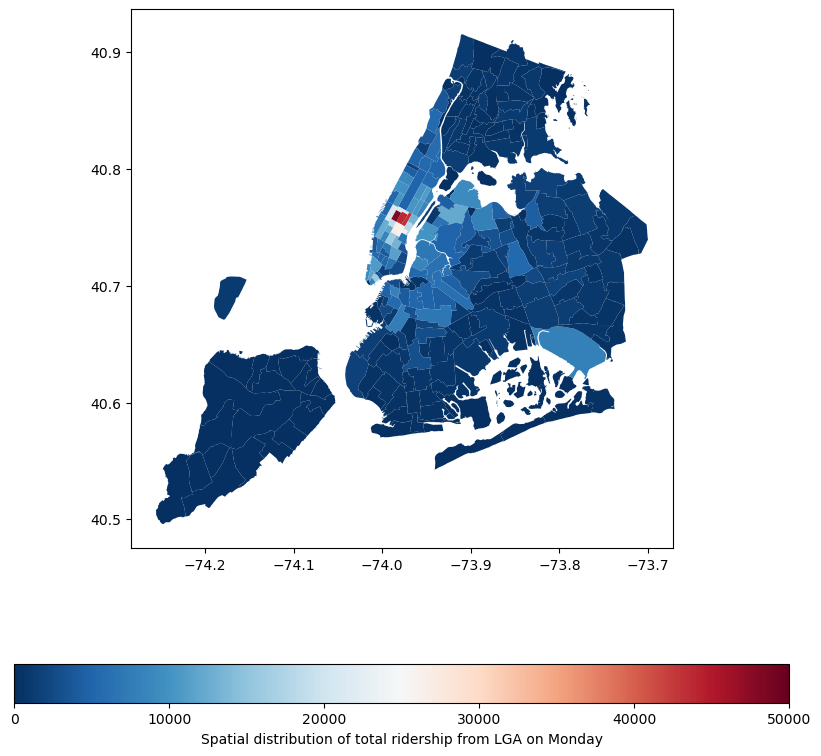

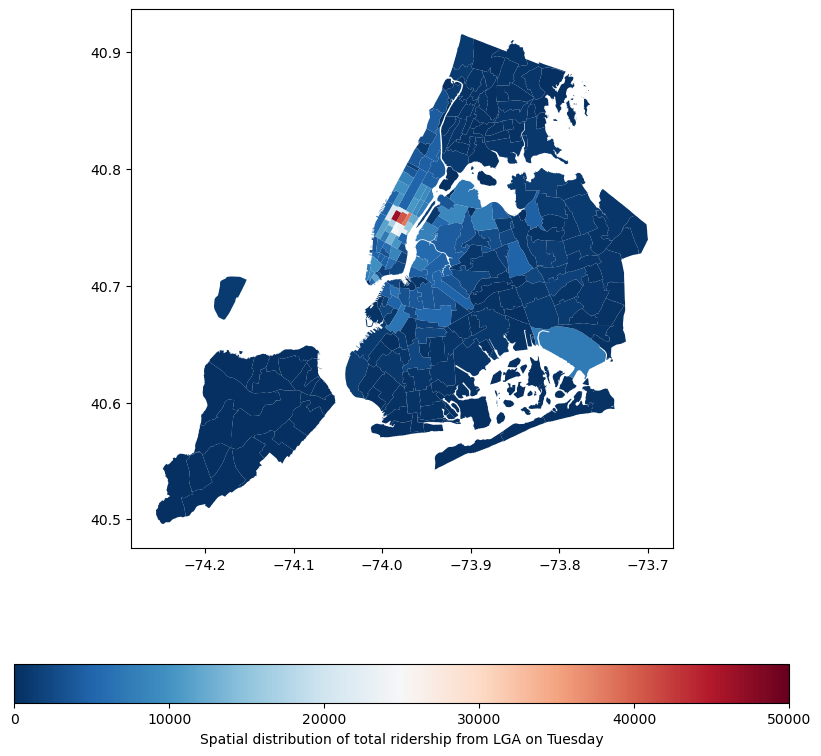

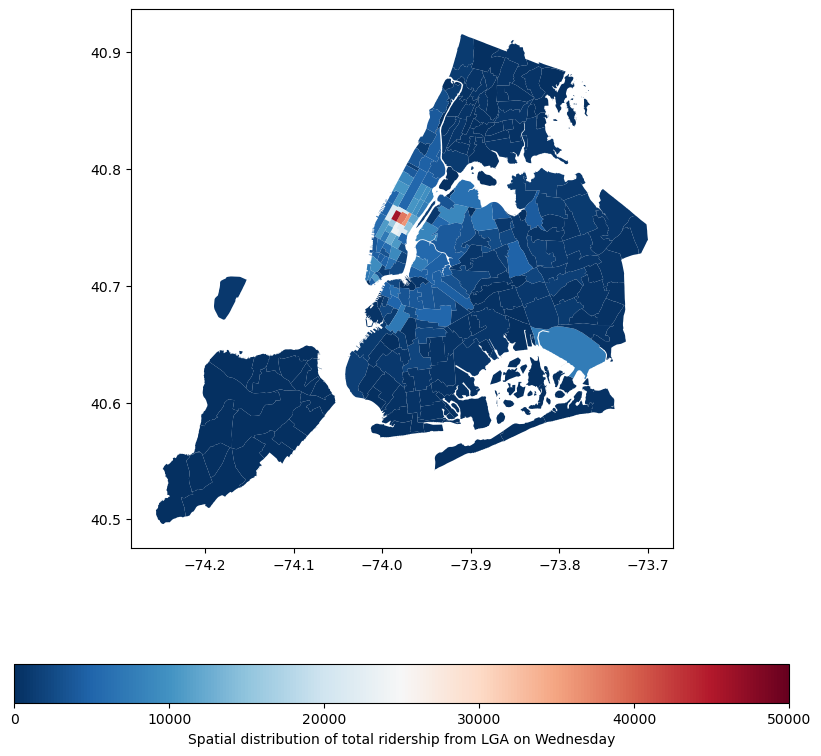

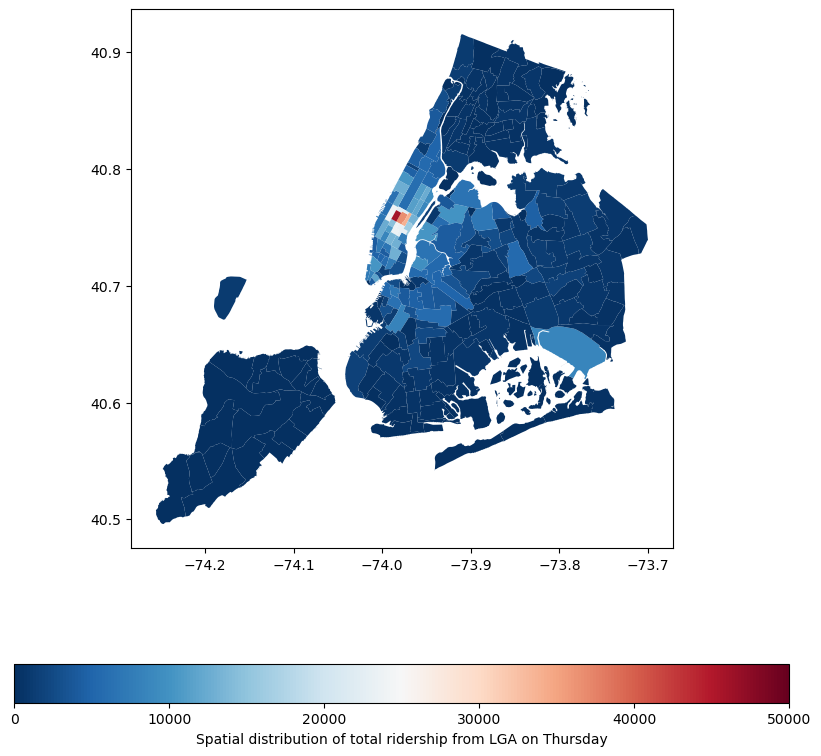

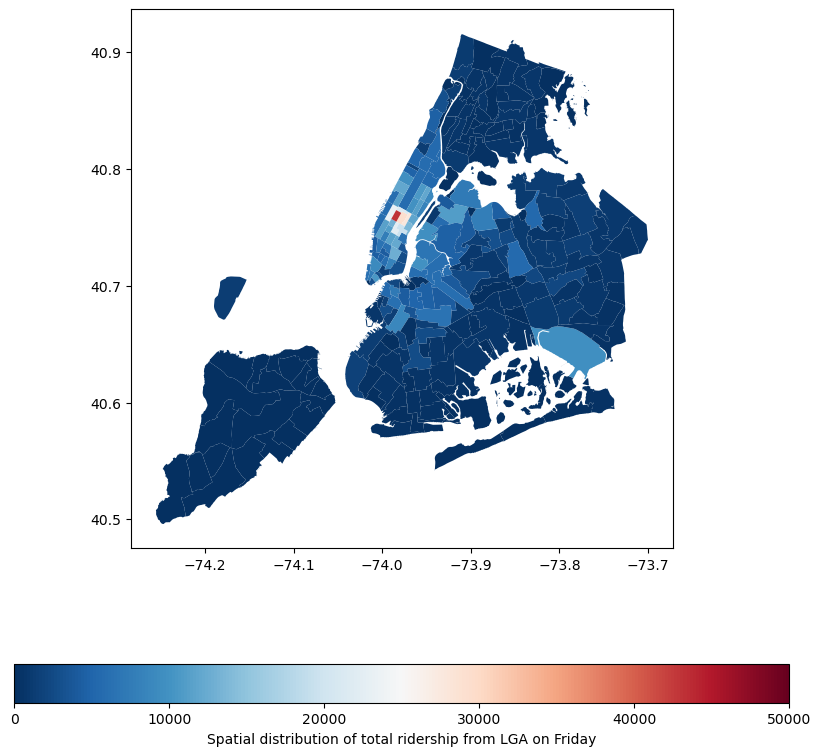

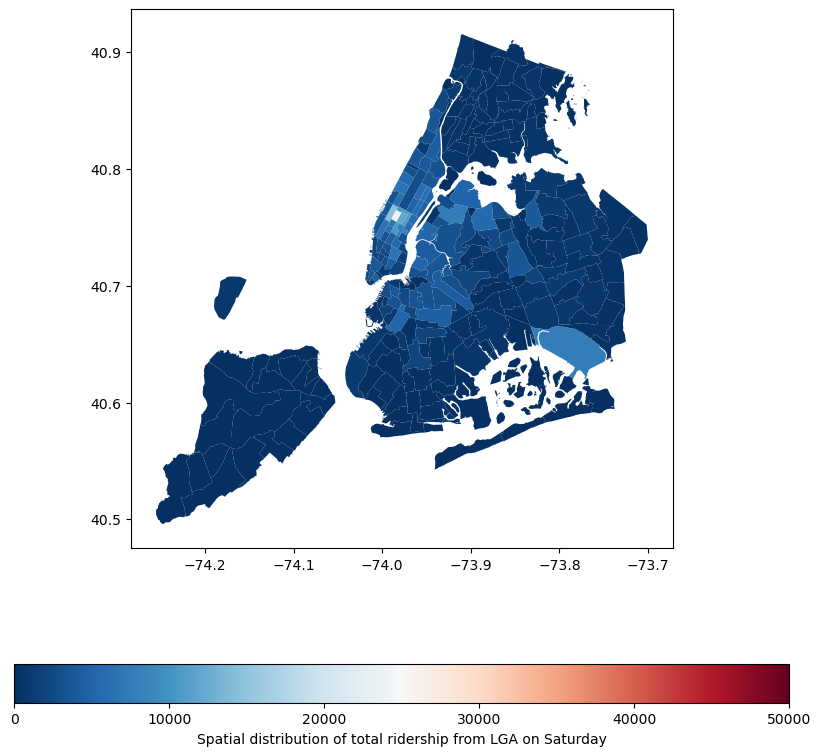

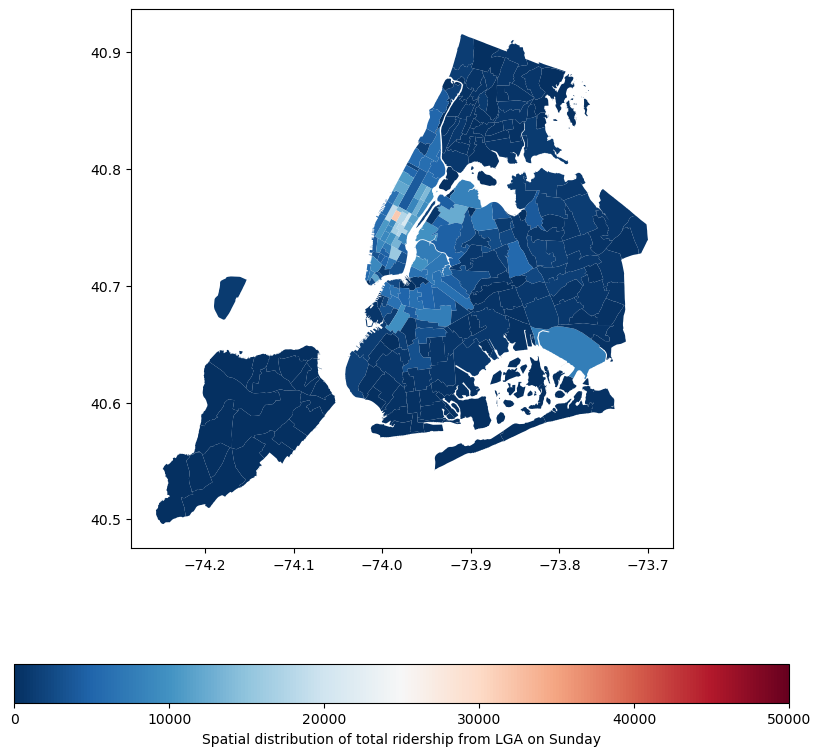

In [15]:
ListDOW = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    Geodf[Geodf['DOW']==i].plot(figsize = (10,10), column='vehicle_count', cmap='RdBu_r', legend=True, vmin = 0,vmax = 50000,
           legend_kwds={'label': 'Spatial distribution of total ridership from LGA on '+ListDOW[i],'orientation': 'horizontal'})


## Task 2: Data preprocessing (10pts)

### Q1. aggregate ridership to date-hour level (over the entire city for all the drop off locations aggregated together), merge with the flight arrival data (5pts)
Note: date-hour level means that you have to find the count for every hour of the day for each day.
Hint: you may need to precess data format in two datasets before merge.

In [16]:
data = TaxiRidership.groupby(by=['Date','Hour','DOW','day'], as_index=False).sum()[['Date','vehicle_count','Hour','DOW','day']]
data

,Date,vehicle_count,Hour,DOW,day
0,2018-01-01 00:00:00,142.0,0,0,0
1,2018-01-01 01:00:00,23.0,1,0,0
2,2018-01-01 02:00:00,2.0,2,0,0
3,2018-01-01 03:00:00,1.0,3,0,0
4,2018-01-01 04:00:00,13.0,4,0,0
...,...,...,...,...,...
8755,2018-12-31 19:00:00,467.0,19,0,364
8756,2018-12-31 20:00:00,599.0,20,0,364
8757,2018-12-31 21:00:00,384.0,21,0,364
8758,2018-12-31 22:00:00,410.0,22,0,364


In [17]:
Data = FlightArrival.merge(data,left_on='Date',right_on='Date')
Data

,Date,arrivals,vehicle_count,Hour,DOW,day
0,2018-01-01 00:00:00,3,142.0,0,0,0
1,2018-01-01 01:00:00,0,23.0,1,0,0
2,2018-01-01 02:00:00,1,2.0,2,0,0
3,2018-01-01 03:00:00,0,1.0,3,0,0
4,2018-01-01 04:00:00,0,13.0,4,0,0
...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,11,467.0,19,0,364
8756,2018-12-31 20:00:00,13,599.0,20,0,364
8757,2018-12-31 21:00:00,8,384.0,21,0,364
8758,2018-12-31 22:00:00,8,410.0,22,0,364


### Q2. add time-lagged arrivals (1,2,3,4,5,6..12 hours before) - 5pts

Taxi and FHV ridership volume is impacted by flight arrivals. Intuitively, more flights bring more passengers, and more ridership eventually. However, the hourly ridership volume may not only be related to flight arrivals in the same hour, arrivals 1 hour, 2 hours ago could impact ridership as well, as travelers need some time to pass the customs or wait for luggage. Please add lag of `arrivals` as additional features, and name new features as `lag1` for `arrivals` 1 hour ago, and `lag2` for 2 hours before and so on. You may use the `shift` function in pandas to add arrivals lag values. For example, df['arrivals'].shift(1) means adding 1 hour lag value of arrivals. `iloc` function works as well.

In [18]:
dataset = Data.copy()

In [19]:
dataset

,Date,arrivals,vehicle_count,Hour,DOW,day
0,2018-01-01 00:00:00,3,142.0,0,0,0
1,2018-01-01 01:00:00,0,23.0,1,0,0
2,2018-01-01 02:00:00,1,2.0,2,0,0
3,2018-01-01 03:00:00,0,1.0,3,0,0
4,2018-01-01 04:00:00,0,13.0,4,0,0
...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,11,467.0,19,0,364
8756,2018-12-31 20:00:00,13,599.0,20,0,364
8757,2018-12-31 21:00:00,8,384.0,21,0,364
8758,2018-12-31 22:00:00,8,410.0,22,0,364


In [20]:
for i in range(1, 13):
    dataset[f'lag{i}'] = dataset['arrivals'].shift(i)
    
dataset

,Date,arrivals,vehicle_count,Hour,DOW,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,3,142.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,0,23.0,1,0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,1,2.0,2,0,0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,0,1.0,3,0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,0,13.0,4,0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,11,467.0,19,0,364,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,11.0
8756,2018-12-31 20:00:00,13,599.0,20,0,364,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0
8757,2018-12-31 21:00:00,8,384.0,21,0,364,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0
8758,2018-12-31 22:00:00,8,410.0,22,0,364,8.0,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0


In [21]:
dataset.iloc[:20]

,Date,arrivals,vehicle_count,Hour,DOW,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,3,142.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,0,23.0,1,0,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,1,2.0,2,0,0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,0,1.0,3,0,0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,0,13.0,4,0,0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-01-01 05:00:00,0,13.0,5,0,0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-01 06:00:00,0,15.0,6,0,0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01 07:00:00,5,46.0,7,0,0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
8,2018-01-01 08:00:00,14,248.0,8,0,0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN
9,2018-01-01 09:00:00,15,443.0,9,0,0,14.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN


In [22]:
dataset0 = dataset.copy()
#dataset0 = dataset0[(f'lag{i}'for i in range(1,13))].fillna(0,inplace = True)

In [23]:
dataset0 = dataset0.fillna(0)

In [24]:
dataset0

,Date,arrivals,vehicle_count,Hour,DOW,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,3,142.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 01:00:00,0,23.0,1,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 02:00:00,1,2.0,2,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 03:00:00,0,1.0,3,0,0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 04:00:00,0,13.0,4,0,0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,11,467.0,19,0,364,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0,11.0
8756,2018-12-31 20:00:00,13,599.0,20,0,364,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0,22.0
8757,2018-12-31 21:00:00,8,384.0,21,0,364,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0,23.0
8758,2018-12-31 22:00:00,8,410.0,22,0,364,8.0,13.0,11.0,12.0,21.0,20.0,17.0,21.0,27.0,17.0,11.0,28.0


## Task 3. Data Exploration (20pts)

### Q1 (5pts). Print some dataset characteristics: number of records, the total number of FHV and taxi trips, total number of arriving flights


In [25]:
print('the number of records is',dataset.Date.count())
print('the total number of FHV and taxi trips is',int(dataset.vehicle_count.sum()))
print('the total number of arriving flights is',dataset.arrivals.sum())

the number of records is 8760
the total number of FHV and taxi trips is 5430922
the total number of arriving flights is 163713


### Q2 (10pts). Plot a probability distribution function of hourly ridership volume on weekdays and weekend using standardized data, and apply t-test to check whether there is a significant difference of hourly ridership between each day of week and the rest of the days, $\alpha=0.05$ Report hypothesis testing result in a $7\times1$ table, index name should be day of week (e.g. Monday), values should be True or False (True for P < 0.05).
Hint: You may use norm.pdf function in scipy.stats to calculate the probability distribution, and standardize at first.

In [26]:
Data['standardized data'] = (Data.vehicle_count - Data.vehicle_count.mean())/Data.vehicle_count.std()

In [27]:
Data.head()

,Date,arrivals,vehicle_count,Hour,DOW,day,standardized data
0,2018-01-01 00:00:00,3,142.0,0,0,0,-1.057751
1,2018-01-01 01:00:00,0,23.0,1,0,0,-1.321100
2,2018-01-01 02:00:00,1,2.0,2,0,0,-1.367574
3,2018-01-01 03:00:00,0,1.0,3,0,0,-1.369787
4,2018-01-01 04:00:00,0,13.0,4,0,0,-1.343231


In [28]:
weekdays = Data[Data['DOW']<5]
weekends = Data[Data['DOW']>=5]

In [29]:
weekdays_gbh = weekdays.groupby(['Hour']).agg({'vehicle_count':'sum'})
weekends_gbh = weekends.groupby(['Hour']).agg({'vehicle_count':'sum'})

In [30]:
weekdays_gbh['standardized data'] = (weekdays_gbh.vehicle_count - weekdays_gbh.vehicle_count.mean())/weekdays_gbh.vehicle_count.std()
weekends_gbh['standardized data'] = (weekends_gbh.vehicle_count - weekends_gbh.vehicle_count.mean())/weekends_gbh.vehicle_count.std()

In [31]:
from scipy.stats import norm
import seaborn as sns

def dist_pdf(x):
    mu = x.mean()
    sigma = x.std()

    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x, hist=True, kde=True, 
        bins=50,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})

    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)


    print('Mean = {:.2f}'.format(mu))
    print('Std dev = {:.2f}'.format(sigma))

    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100)
    y_values = norm(mu, sigma)
    plt.plot(h, y_values.pdf(h),color = 'red')

For weekdays:


Mean = -0.00
Std dev = 1.00


C:\Users\14367\AppData\Local\Temp\ipykernel_8664\2266315917.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, hist=True, kde=True,


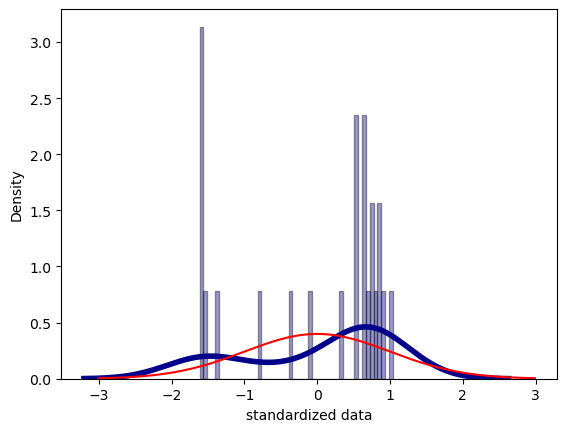

In [32]:
print("For weekdays:\n\n")
dist_pdf(weekdays_gbh['standardized data'])

For weekends:


Mean = -0.00
Std dev = 1.00


C:\Users\14367\AppData\Local\Temp\ipykernel_8664\2266315917.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, hist=True, kde=True,


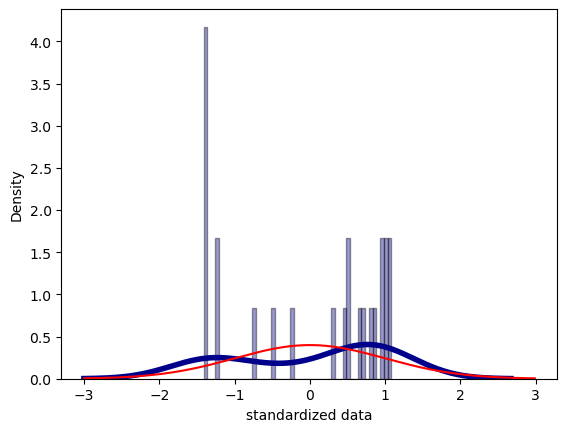

In [33]:
print("For weekends:\n\n")
dist_pdf(weekends_gbh['standardized data'])

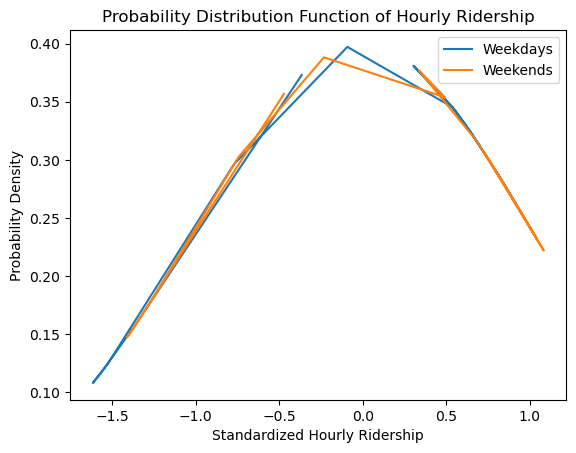

In [34]:
wd = stats.norm.pdf(weekdays_gbh['standardized data'])
we = stats.norm.pdf(weekends_gbh['standardized data'])

plt.plot(weekdays_gbh['standardized data'], wd, label='Weekdays',)
plt.plot(weekends_gbh['standardized data'], we, label='Weekends',)

plt.xlabel('Standardized Hourly Ridership')
plt.ylabel('Probability Density')
plt.title('Probability Distribution Function of Hourly Ridership')
plt.legend()

plt.show()

In [35]:
alpha = 0.05
R = []

In [36]:
for i in range(7):
    t_stat, p_value = stats.ttest_ind(Data.loc[Data['DOW'] == i, 'standardized data'],
                                      Data.loc[Data['DOW'] != i, 'standardized data'])
    if p_value<0.05:
        R.append('True')
    else:
        R.append('False')
    
    print(p_value)

5.269847874106512e-17
0.1694463092394255
0.8410123295393004
2.7418635128922185e-08
0.0001340000217808487
1.2644011492227274e-97
0.1822251807495392


In [37]:
htresult = pd.DataFrame(R, columns=['Result'], index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print(htresult)

          Result
Monday      True
Tuesday    False
Wednesday  False
Thursday    True
Friday      True
Saturday    True
Sunday     False


### Q3(5pts).  Plot the timeline of the `vehicle_count` and `arrivals` for the month having the highest taxi ridership (the sum of vehicle count in the whole month). As `arrivals` and `vehicle_count` have different scales, standardize each dataset first.

In [38]:
dataset['standardized vehicle_count'] = (dataset.vehicle_count - dataset.vehicle_count.mean())/dataset.vehicle_count.std()
dataset['standardized arrivals'] = (dataset.arrivals - dataset.arrivals.mean())/dataset.arrivals.std()

In [39]:
dataset['Month']=pd.DatetimeIndex(dataset.Date).month

In [40]:
dataset1=dataset[['Month','standardized vehicle_count','standardized arrivals']].groupby(by='Month',as_index=False).sum()
highest_month = dataset1['standardized vehicle_count'].idxmax()

In [41]:
highest_month

10

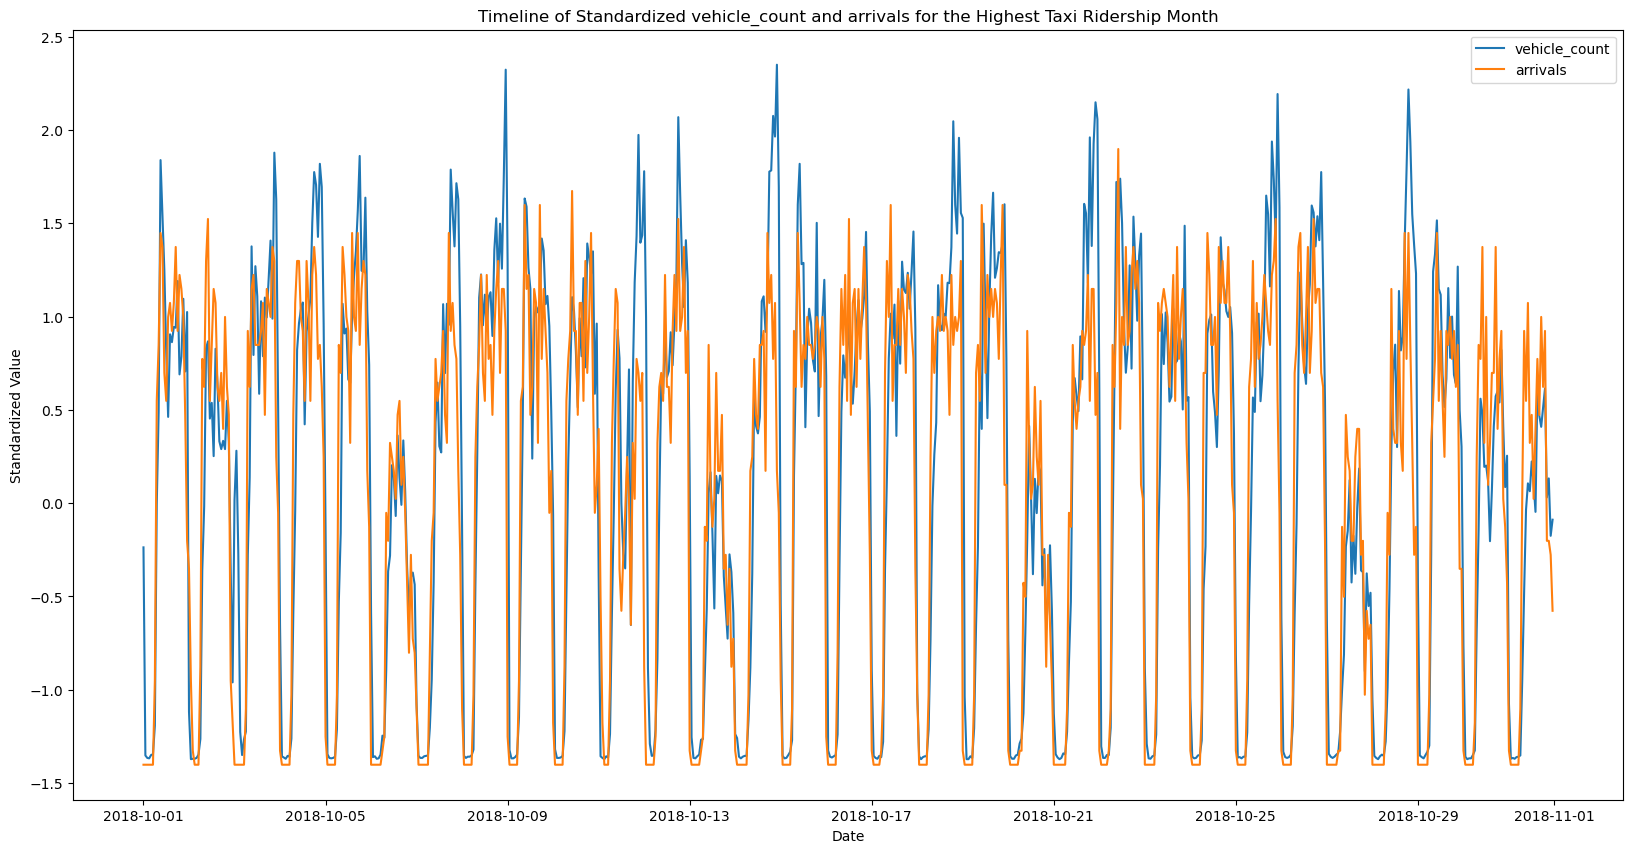

In [42]:
highest_month_data = dataset[dataset['Month']==highest_month]

plt.figure(figsize=(20, 10))
plt.plot(highest_month_data['Date'], highest_month_data['standardized vehicle_count'], label='vehicle_count')
plt.plot(highest_month_data['Date'], highest_month_data['standardized arrivals'], label='arrivals')

plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.title('Timeline of Standardized vehicle_count and arrivals for the Highest Taxi Ridership Month')
plt.legend()

plt.show()

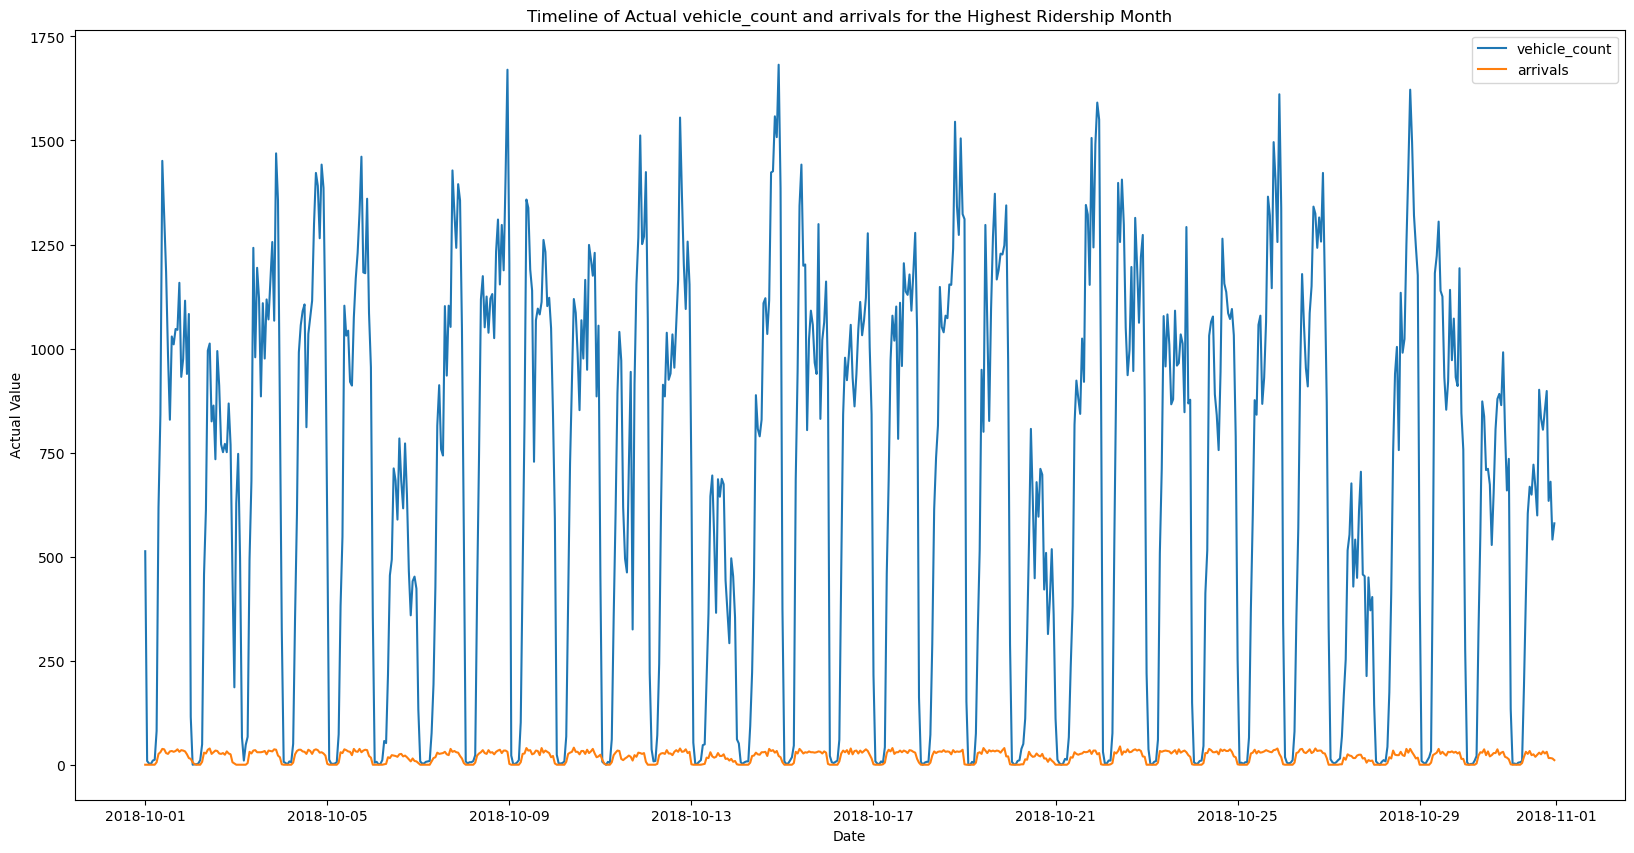

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(highest_month_data['Date'], highest_month_data['vehicle_count'], label='vehicle_count')
plt.plot(highest_month_data['Date'], highest_month_data['arrivals'], label='arrivals')

plt.xlabel('Date')
plt.ylabel('Actual Value')
plt.title('Timeline of Actual vehicle_count and arrivals for the Highest Ridership Month')
plt.legend()

plt.show()

## Task 4: Build Linear Regression Model of FHV and taxi ridership vs Arrivals data (35pts - 5pts each except of Q5 - 10 pts)

### Q1. split the data into training, validation and test samples (first 90 days for training, next 180 for validation, last 90 for test)


In [44]:
len(dataset.day.unique())# totally 365 days in the dataset

365

In [45]:
dataset

,Date,arrivals,vehicle_count,Hour,DOW,day,lag1,lag2,lag3,lag4,...,lag6,lag7,lag8,lag9,lag10,lag11,lag12,standardized vehicle_count,standardized arrivals,Month
0,2018-01-01 00:00:00,3,142.0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.057751,-1.176750,1
1,2018-01-01 01:00:00,0,23.0,1,0,0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.321100,-1.401769,1
2,2018-01-01 02:00:00,1,2.0,2,0,0,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.367574,-1.326763,1
3,2018-01-01 03:00:00,0,1.0,3,0,0,1.0,0.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.369787,-1.401769,1
4,2018-01-01 04:00:00,0,13.0,4,0,0,0.0,1.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.343231,-1.401769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,11,467.0,19,0,364,12.0,21.0,20.0,17.0,...,27.0,17.0,11.0,28.0,23.0,22.0,11.0,-0.338521,-0.576700,12
8756,2018-12-31 20:00:00,13,599.0,20,0,364,11.0,12.0,21.0,20.0,...,21.0,27.0,17.0,11.0,28.0,23.0,22.0,-0.046403,-0.426688,12
8757,2018-12-31 21:00:00,8,384.0,21,0,364,13.0,11.0,12.0,21.0,...,17.0,21.0,27.0,17.0,11.0,28.0,23.0,-0.522202,-0.801719,12
8758,2018-12-31 22:00:00,8,410.0,22,0,364,8.0,13.0,11.0,12.0,...,20.0,17.0,21.0,27.0,17.0,11.0,28.0,-0.464663,-0.801719,12


In [46]:
train_data = dataset[dataset['day']<90] #first 90 days
validation_data = dataset[(dataset['day']>=90) & (dataset['day']<270)] #next 180 days
test_data = dataset[(dataset['day']>=275) & (dataset['day']<365)] #last 90 days

In [47]:
print(
    len(train_data.day.unique()),
    len(validation_data.day.unique()),
    len(test_data.day.unique())
)

90 180 90


### Q2.  Build an OLS model

Build an OLS model with intercept (you may want to use smf.ols) over the training dataset using `arrivals` as a sole predictor for `vehicle_count`. Check p-value for `arrivals`. What does it indicate? Report the 99% confidence interval for arrivals's coefficient. Scatter plot for ridership and flight arrival, include the predictive line.

In [48]:
lm = smf.ols(formula='vehicle_count~arrivals', data=train_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     5657.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:35   Log-Likelihood:                -14690.
No. Observations:                2160   AIC:                         2.938e+04
Df Residuals:                    2158   BIC:                         2.939e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.8315      7.772      9.757      0.0

In [49]:
conf_interval = lm.conf_int(0.01)
print(conf_interval)

                   0          1
Intercept  55.794760  95.868142
arrivals   25.382394  27.184322


In [50]:
print('the 99% confidence interval for arrivals\'s coefficient is',list(conf_interval.loc['arrivals']))

the 99% confidence interval for arrivals's coefficient is [25.382394407700627, 27.184321755411343]


C:\Users\14367\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


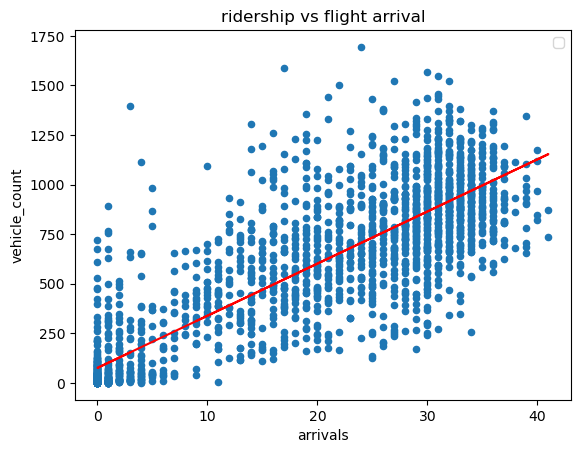

In [51]:
fig, ax = plt.subplots()
train_data.plot(ax=ax,kind='scatter',x='arrivals', y='vehicle_count')
ax.plot(train_data['arrivals'],lm.predict(),'r-')
plt.title('ridership vs flight arrival')
plt.legend()
plt.show()

### Q3. Consider Impact of immediate history of arrivals
by adding time lags - add all 12 lag variables into the regression above

There is always some delay between passengers arrival and departure (e.g. passing customs, picking up luggage, etc). `vehicle_count` might be more related to historical values of flight arrivals (lag) rather than immediate `arrivals`. Engineer a formula with all the following variables and run the regression:
* arrival, lag1, ..., lagN: that happens 1hr, ..., N=12 hr ahead.
Which of the variables have a statistically significant impact according to p-values?

In [52]:
train_data.head(20)

,Date,arrivals,vehicle_count,Hour,DOW,day,lag1,lag2,lag3,lag4,...,lag6,lag7,lag8,lag9,lag10,lag11,lag12,standardized vehicle_count,standardized arrivals,Month
0,2018-01-01 00:00:00,3,142.0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.057751,-1.176750,1
1,2018-01-01 01:00:00,0,23.0,1,0,0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.321100,-1.401769,1
2,2018-01-01 02:00:00,1,2.0,2,0,0,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.367574,-1.326763,1
3,2018-01-01 03:00:00,0,1.0,3,0,0,1.0,0.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.369787,-1.401769,1
4,2018-01-01 04:00:00,0,13.0,4,0,0,0.0,1.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.343231,-1.401769,1
5,2018-01-01 05:00:00,0,13.0,5,0,0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.343231,-1.401769,1
6,2018-01-01 06:00:00,0,15.0,6,0,0,0.0,0.0,0.0,1.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.338805,-1.401769,1
7,2018-01-01 07:00:00,5,46.0,7,0,0,0.0,0.0,0.0,0.0,...,0.0,3.0,NaN,NaN,NaN,NaN,NaN,-1.270201,-1.026738,1
8,2018-01-01 08:00:00,14,248.0,8,0,0,5.0,0.0,0.0,0.0,...,1.0,0.0,3.0,NaN,NaN,NaN,NaN,-0.823172,-0.351682,1
9,2018-01-01 09:00:00,15,443.0,9,0,0,14.0,5.0,0.0,0.0,...,0.0,1.0,0.0,3.0,NaN,NaN,NaN,-0.391634,-0.276675,1


In [53]:
td0 = train_data.copy()
td0 = td0.fillna(0)

In [54]:
lm10 = smf.ols(formula='vehicle_count~arrivals+'+'+'.join(td0.columns[6:18]), data=td0).fit()
print(lm10.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1012.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:36   Log-Likelihood:                -13957.
No. Observations:                2160   AIC:                         2.794e+04
Df Residuals:                    2146   BIC:                         2.802e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.0989      9.390     -5.442      0.0

In [55]:
# After using 0 to fill train_data's nan values, p-values of arrivals, lag1, lag2, lag3, lag9, lag12 all below 0.05. 
# They all have statistically significant impact just according to p-values.

In [56]:
lm1 = smf.ols(formula='vehicle_count~arrivals+'+'+'.join(train_data.columns[6:18]), data=train_data).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:36   Log-Likelihood:                -13884.
No. Observations:                2148   AIC:                         2.780e+04
Df Residuals:                    2134   BIC:                         2.788e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.5959      9.574     -5.598      0.0

In [57]:
# Using whole train dataset, p-values of arrivals, lag1, lag2, lag3, lag9 all below 0.05. 
# They also all have statistically significant impact just according to p-values.

### Q4: Incorporate Temporal Patterns

adding categorical variables for day of week and hour of the day.

From the visualization in task1Q3, you may see that both - taxi ridership as well as arrivals follow a somewhat periodic temporal pattern. Intuitively, this is true for most traffic flows following daily rhythms including rush hours, and also varying over the course of the week. Usually, we add dummy/categorical variables (Boolean variable: 1 for True and 0 for False) to encapsulate people's traveling patterns during different time periods.

Note that it would not make sense to add hour and dow as regular regressors as we can't anticipate their linear numeric impact. Instead, the expression `C(.)` or `pd.get_dummies` could be used in the regression formulae in order to treat those variables as categorical adding corresponding dummy variables to account for their possible discrete values.

Perform the regression of `vehicle_count` ridership against `arrivals`, lags, and temporal categorical variables.

In [58]:
td1 = train_data.copy()
td1 = pd.get_dummies(td1, columns=['DOW', 'Hour'], drop_first=False)

In [59]:
td1.columns[7:51]

Index(['lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11',
       'lag12', 'standardized vehicle_count', 'standardized arrivals', 'Month',
       'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'Hour_0',
       'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7',
       'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13',
       'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19',
       'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [60]:
td1.insert(4,'Month',td1.pop('Month'))
td1.insert(5,'standardized vehicle_count',td1.pop('standardized vehicle_count'))
td1.insert(6,'standardized arrivals',td1.pop('standardized arrivals'))

In [61]:
for i in range(6):
    td1[f'DOW_{i}'] = td1[f'DOW_{i}'].astype('float64')

In [62]:
for j in range(24):
    td1[f'Hour_{j}'] = td1[f'Hour_{j}'].astype('float64')

In [63]:
td1.head()

,Date,arrivals,vehicle_count,day,Month,standardized vehicle_count,standardized arrivals,lag1,lag2,lag3,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2018-01-01 00:00:00,3,142.0,0,1,-1.057751,-1.176750,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 01:00:00,0,23.0,0,1,-1.321100,-1.401769,3.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 02:00:00,1,2.0,0,1,-1.367574,-1.326763,0.0,3.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 03:00:00,0,1.0,0,1,-1.369787,-1.401769,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 04:00:00,0,13.0,0,1,-1.343231,-1.401769,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
lm2 = smf.ols(formula='vehicle_count~arrivals+'+'+'.join(td1.columns[7:51]), data=td1).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     448.5
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:36   Log-Likelihood:                -13522.
No. Observations:                2148   AIC:                         2.713e+04
Df Residuals:                    2105   BIC:                         2.737e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.7069      9.394      4.972      0.0

In [65]:
td2 = td1.copy()
td2 = td2.fillna(0) #remove nan values
td2.head()

,Date,arrivals,vehicle_count,day,Month,standardized vehicle_count,standardized arrivals,lag1,lag2,lag3,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2018-01-01 00:00:00,3,142.0,0,1,-1.057751,-1.176750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 01:00:00,0,23.0,0,1,-1.321100,-1.401769,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 02:00:00,1,2.0,0,1,-1.367574,-1.326763,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 03:00:00,0,1.0,0,1,-1.369787,-1.401769,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 04:00:00,0,13.0,0,1,-1.343231,-1.401769,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
lm2d = smf.ols(formula='vehicle_count~arrivals+'+'+'.join(td2.columns[7:51]), data=td2).fit()
print(lm2d.summary()) # the Regression of train dataset after filling nan values.

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     453.6
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:36   Log-Likelihood:                -13592.
No. Observations:                2160   AIC:                         2.727e+04
Df Residuals:                    2117   BIC:                         2.752e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.0474      9.083      5.180      0.0

### Q5. Perform feature selection for lag variables (10pts)
As you may see not all the lag variables have a statistically significant impact on the regression. Maybe some of them are not really relevant?
Try different amounts of lag variables m=0,1,...,12 (include m most recent arrival volumes/lags) using a loop for training the above regression over the training sample, report and plot the out-of-sample R2 over the validation sample as the function of m and pick the m which maximizes it. Evaluate the final regression over the test sample.

In [67]:
DF1 = pd.get_dummies(dataset, columns=['DOW','Hour'], drop_first=False)

In [68]:
DF1['lag0'] = DF1['arrivals']

Train1=DF1[DF1['day'] < 90] 
Valid1=DF1[(DF1['day'] > 89) & (DF1['day'] < 270)] 
Test1=DF1[(DF1['day'] > 274) & (DF1['day'] < 365)] 


len(Train1.day.unique()),len(Valid1.day.unique()),len(Test1.day.unique())


(90, 180, 90)

In [69]:
TrainR2=[0]*14
ValidR2=[0]*14
lm3=[0]*14

In [70]:
formula2='vehicle_count~'+'+'.join(['Hour_%d'%p for p in range(0,24)]) + '+'+'+'.join(['DOW_%d'%p for p in range(0,7)]); formula2

'vehicle_count~Hour_0+Hour_1+Hour_2+Hour_3+Hour_4+Hour_5+Hour_6+Hour_7+Hour_8+Hour_9+Hour_10+Hour_11+Hour_12+Hour_13+Hour_14+Hour_15+Hour_16+Hour_17+Hour_18+Hour_19+Hour_20+Hour_21+Hour_22+Hour_23+DOW_0+DOW_1+DOW_2+DOW_3+DOW_4+DOW_5+DOW_6'

In [71]:
for M in range(1,14):
    formula=formula2 +'+'+'+'.join(['lag%d'%p for p in range(0,M)]);
    lm3[M] = smf.ols(formula=formula, data = Train1).fit()
    Valid1['pred_v_count']=lm3[M].predict(Valid1)
    ValidR2[M]=1-((Valid1['pred_v_count']-Valid1['vehicle_count'])**2).sum()/((Valid1['vehicle_count']-Valid1['vehicle_count'].mean())**2).sum()
    TrainR2[M]=lm3[M].rsquared

C:\Users\14367\AppData\Local\Temp\ipykernel_8664\1757212160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Valid1['pred_v_count']=lm3[M].predict(Valid1)
C:\Users\14367\AppData\Local\Temp\ipykernel_8664\1757212160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Valid1['pred_v_count']=lm3[M].predict(Valid1)
C:\Users\14367\AppData\Local\Temp\ipykernel_8664\1757212160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [72]:
ValidR2

[0,
 0.8239650449897558,
 0.8542208128666982,
 0.8559351583608443,
 0.8550756045368695,
 0.8550388226709555,
 0.8548442256450473,
 0.8548414145273984,
 0.8549355168196549,
 0.8551711672410685,
 0.8558485632418458,
 0.8555049799066008,
 0.8556445104148884,
 0.8554947166392534]

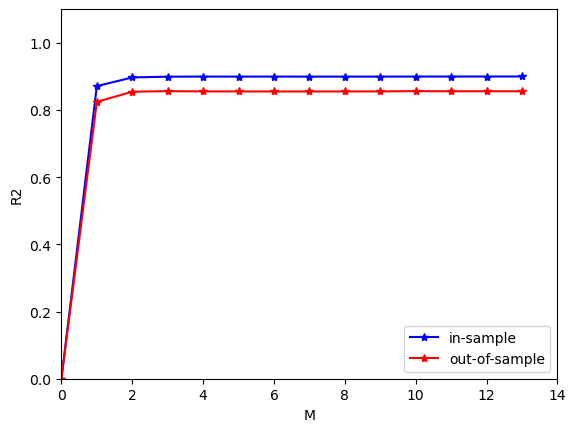

In [73]:
plt.plot(range(0,14),TrainR2[:],'b-*',label='in-sample')
plt.plot(range(0,14),ValidR2[:],'r-*',label='out-of-sample')
plt.xlabel('M')
plt.ylabel('R2')
plt.ylim(0,1.1)
plt.xlim(0,14)
plt.legend(loc='lower right')

In [74]:
M=np.argmax(ValidR2); M

3

In [75]:
lm3[M].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     590.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:38   Log-Likelihood:                -13591.
No. Observations:                2158   AIC:                         2.725e+04
Df Residuals:                    2125   BIC:                         2.743e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.7006      7.750      7.832      0.000      45.502      75.899
Hour_0       -10.0497     16.401     -0.613      0.540     -42.213      22.113
Hour_1      -128.5505     16.919     -7.598      0.000    -161.729     -95.372
Hour_2       -81.2241     15.813     -5.137      0.000    -112.234     -50.214
Hour_3       -68.5928     15.988     -4.290      0.000     -99.946     -37.239
Hour_4       -63.3434     16.032     -3.951      0.000     -94.783     -31.903
Hour_5       -61.0257     16.043     -3.804      0.000     -92.487     -29.565
Hour_6       -64.4748     15.913     -4.052      0.000     -95.682     -33.268
Hour_7       -64.7332     18.016     -3.593      0.000    -100.064     -29.402
Hour_8       -91.5830     18.044     -5.076      0.000    -126.969     -56.197
Hour_9       -72.2756     14.411     -5.015      0.000    -100.536     -44.015
Hour_10      -24.3761     14.839     -1.643      0.101     -53.476       4.724
Hour_11      -72.4061     14.824     -4.884      0.000    -101.477     -43.335
Hour_12      -41.6175     14.808     -2.810      0.005     -70.657     -12.578
Hour_13      -63.8247     14.208     -4.492      0.000     -91.687     -35.962
Hour_14      -28.9190     14.388     -2.010      0.045     -57.134      -0.704
Hour_15        0.0646     14.506      0.004      0.996     -28.382      28.511
Hour_16       37.0519     14.606      2.537      0.011       8.409      65.695
Hour_17       68.7936     14.607      4.710      0.000      40.148      97.439
Hour_18       81.9993     14.608      5.613      0.000      53.352     110.646
Hour_19      108.0288     14.513      7.444      0.000      79.569     136.489
Hour_20       69.5661     14.446      4.816      0.000      41.236      97.896
Hour_21      220.9226     14.317     15.431      0.000     192.846     248.999
Hour_22      184.2601     14.434     12.766      0.000     155.954     212.566
Hour_23      227.0096     14.530     15.624      0.000     198.516     255.503
DOW_0         54.6604      7.409      7.378      0.000      40.131      69.190
DOW_1        -16.0449      7.327     -2.190      0.029     -30.414      -1.675
DOW_2        -39.8387      7.000     -5.691      0.000     -53.567     -26.111
DOW_3         31.9875      7.226      4.427      0.000      17.817      46.158
DOW_4         -1.4492      7.160     -0.202      0.840     -15.490      12.591
DOW_5        -23.7582      7.333     -3.240      0.001     -38.139      -9.377
DOW_6         55.1437      7.232      7.625      0.000      40.960      69.327
lag0          10.2853      0.639     16.096      0.000       9.032      11.538
lag1          11.7625      0.692     16.988      0.000      10.405      13.120
lag2           4.4912      0.631      7.117      0.000       3.254       5.729
==============================================================================
Om

In [76]:
Test1['pred_v_count']=lm3[M].predict(Test1)
TestR2=1-((Test1['pred_v_count']-Test1['vehicle_count'])**2).sum()/((Test1['vehicle_count']-Test1['vehicle_count'].mean())**2).sum()

print("R2 of the model on test sample:",TestR2)

R2 of the model on test sample: 0.8183283144229445


C:\Users\14367\AppData\Local\Temp\ipykernel_8664\1660399040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test1['pred_v_count']=lm3[M].predict(Test1)


### Q6. Visualize temporal patterns and lag impacts through bar plots
For the best regression above visualize:
- bar plot of hour vs its impact (slope coefficient)
- bar plot of day of the week vs its impact coefficient
- bar plot of the lag (0 for immediate arrivals, 1,2,... for lags)

In [77]:
print(lm3[M].summary()) 

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     590.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:08:39   Log-Likelihood:                -13591.
No. Observations:                2158   AIC:                         2.725e+04
Df Residuals:                    2125   BIC:                         2.743e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.7006      7.750      7.832      0.0

In [78]:
coef = lm3[M].params
coefdf = pd.DataFrame(coef)

In [79]:
coefdf.reset_index(inplace=True)

In [80]:
hourcoef = coefdf.iloc[1:25]

In [81]:
hourcoef.columns

Index(['index', 0], dtype='object')

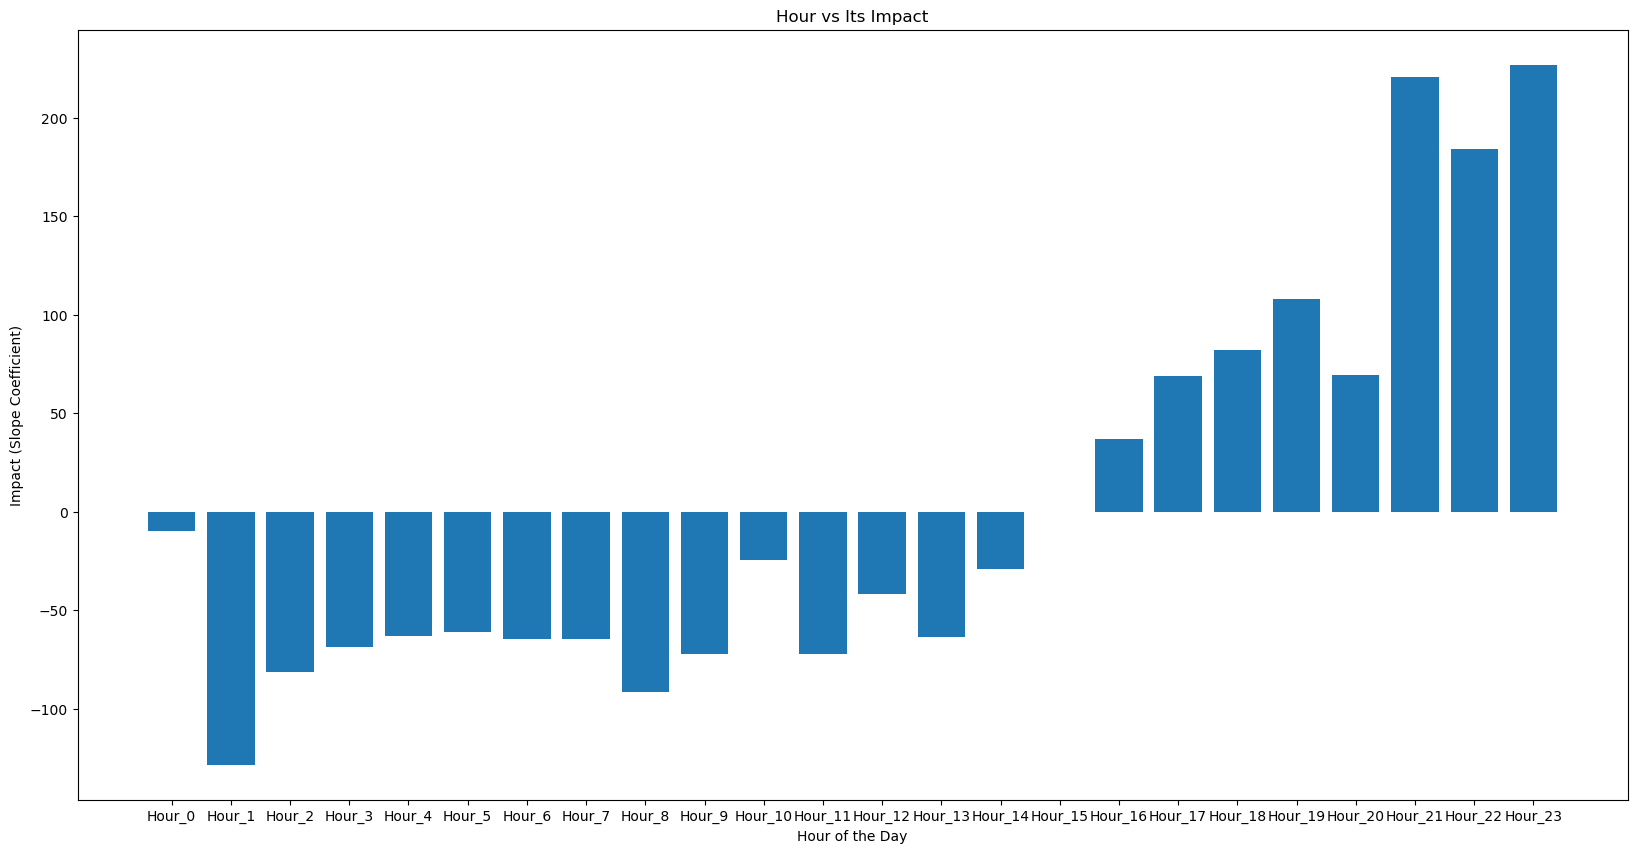

In [82]:
plt.figure(figsize=(20, 10))
plt.bar(hourcoef['index'],hourcoef[0])
plt.xlabel("Hour of the Day")
plt.ylabel("Impact (Slope Coefficient)")
plt.title("Hour vs Its Impact")
plt.show()

In [83]:
dowcoef = coefdf.iloc[25:32]

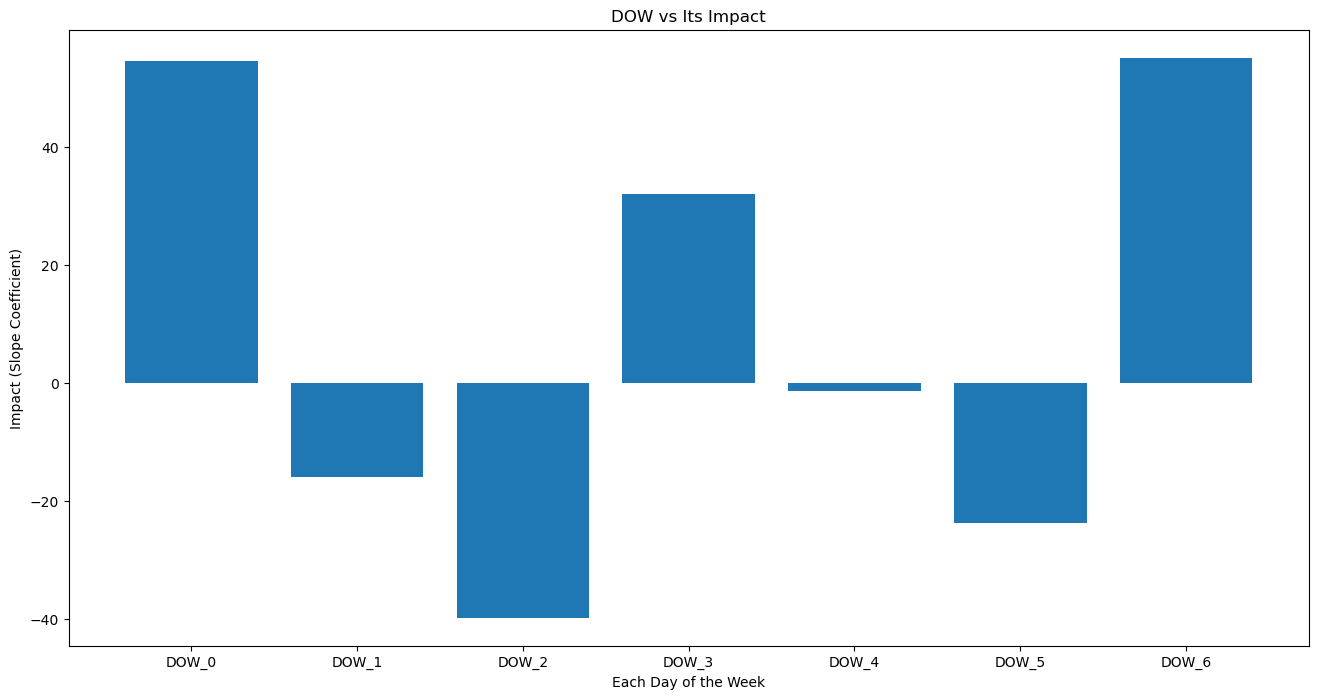

In [84]:
plt.figure(figsize=(16, 8))
plt.bar(dowcoef['index'],dowcoef[0])
plt.xlabel("Each Day of the Week")
plt.ylabel("Impact (Slope Coefficient)")
plt.title("DOW vs Its Impact")
plt.show()

In [85]:
lagcoef = coefdf.iloc[32:]

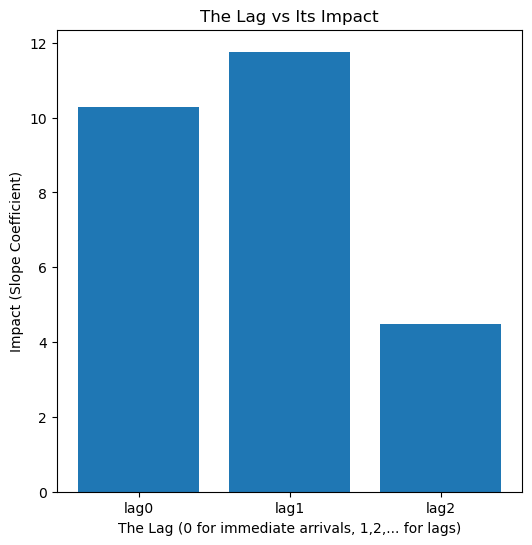

In [86]:
plt.figure(figsize=(6, 6))
plt.bar(lagcoef['index'],lagcoef[0])
plt.xlabel("The Lag (0 for immediate arrivals, 1,2,... for lags)")
plt.ylabel("Impact (Slope Coefficient)")
plt.title("The Lag vs Its Impact")
plt.show()

## Task 5. Cluster the days of the year based on the relative timeline of their FHV and taxi departures from the airport (25pts - 5 pts each)

### Q1 (5pts). From the entire `dataset`, create a dataframe with days as rows, hours as columns and a) FHV, b)taxi departures for each hour as values (feel free to use pd.pivot_table). Normalize each row by the total daily ridership. Merge tables a) and b) horizontally

In [87]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count,DOW,Hour,day
0,1,2018-01-01,0.0,0,0,0
1,2,2018-01-01,0.0,0,0,0
2,3,2018-01-01,0.0,0,0,0
3,4,2018-01-01,0.0,0,0,0
4,5,2018-01-01,0.0,0,0,0


In [88]:
TaxiRidership_pt = TaxiRidership.pivot_table(index = 'day',columns = 'Hour',values = 'vehicle_count',aggfunc='sum')
TaxiRidership_pt

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
0,142.0,23.0,2.0,1.0,13.0,13.0,15.0,46.0,248.0,443.0,...,765.0,865.0,776.0,1182.0,804.0,765.0,744.0,1025.0,1196.0,1079.0
1,791.0,50.0,28.0,2.0,5.0,16.0,24.0,301.0,550.0,1117.0,...,892.0,650.0,820.0,927.0,979.0,940.0,811.0,1048.0,1034.0,735.0
2,674.0,309.0,24.0,3.0,8.0,12.0,44.0,176.0,531.0,777.0,...,700.0,688.0,907.0,1011.0,871.0,713.0,507.0,480.0,566.0,301.0
3,295.0,11.0,2.0,1.0,10.0,15.0,43.0,31.0,32.0,29.0,...,68.0,80.0,40.0,45.0,29.0,28.0,21.0,32.0,37.0,72.0
4,387.0,164.0,29.0,15.0,7.0,14.0,36.0,92.0,89.0,232.0,...,591.0,679.0,723.0,883.0,882.0,950.0,894.0,1055.0,761.0,957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,572.0,124.0,52.0,3.0,4.0,17.0,60.0,174.0,694.0,863.0,...,859.0,968.0,806.0,997.0,1108.0,1136.0,915.0,603.0,942.0,665.0
361,470.0,656.0,390.0,66.0,14.0,15.0,65.0,200.0,536.0,769.0,...,951.0,977.0,983.0,966.0,1075.0,1003.0,907.0,1167.0,1214.0,721.0
362,627.0,139.0,4.0,6.0,5.0,30.0,64.0,122.0,464.0,603.0,...,664.0,975.0,844.0,877.0,1026.0,954.0,1082.0,1048.0,710.0,765.0


In [89]:
TaxiRidership_norm=TaxiRidership_pt.div(TaxiRidership_pt.sum(axis=1), axis=0)
TaxiRidership_norm

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.060942,0.068908,0.061818,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.059794,0.043572,0.054967,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.057823,0.056831,0.074922,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.057239,0.067340,0.033670,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.051142,0.058757,0.062565,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.038981,0.008450,0.003544,0.000204,0.000273,0.001159,0.004089,0.011858,0.047295,0.058812,...,0.058539,0.065967,0.054927,0.067943,0.075508,0.077416,0.062355,0.041093,0.064195,0.045318
361,0.028664,0.040007,0.023785,0.004025,0.000854,0.000915,0.003964,0.012197,0.032689,0.046899,...,0.057998,0.059584,0.059950,0.058913,0.065561,0.061170,0.055315,0.071172,0.074038,0.043971
362,0.045037,0.009984,0.000287,0.000431,0.000359,0.002155,0.004597,0.008763,0.033329,0.043313,...,0.047694,0.070033,0.060623,0.062994,0.073696,0.068525,0.077719,0.075277,0.050998,0.054949


### Q2 (7pts). Try K-means with different numbers of clusters k=2..7, report average Silhouette score for each. Which k is the "optimal" from Silhouette's standpoint?

In [90]:
n = [2, 3, 4, 5, 6, 7]
for i in n:
    km = KMeans(n_clusters=i, random_state=324)
    labels = km.fit_predict(TaxiRidership_norm)
    
    silhouette_avg = silhouette_score(TaxiRidership_norm, labels)
    print("For k ={},".format(i)+" the average silhouette_score is :{}".format(silhouette_avg))

C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =2, the average silhouette_score is :0.18929824985499946


C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =3, the average silhouette_score is :0.2207501936217206


C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =4, the average silhouette_score is :0.23329518409569264


C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =5, the average silhouette_score is :0.2218128107062637


C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =6, the average silhouette_score is :0.1836590707295935


C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For k =7, the average silhouette_score is :0.18480178899144892


In [91]:
# Q: Which k is the "optimal" from Silhouette's standpoint?
# A: k=4 is the "optimal" from Silhouette's standpoint, the average silhouette_score is :0.23329518409569264.

### Q3 (8pts). Perform K-means with the optimal k from above. Report the number of occurrences of each day of the week within each of the clusters. How would you interpret the clusters based on that?
Hint: Create a dictionary of the cluster numbers corresponding to each day of the year, apply it adding a column "cluster" to the dataframe, and use pivot table with aggregation function `count` to collect the numbers above.

In [92]:
km = KMeans(random_state=324,n_clusters=4) 
res = km.fit(TaxiRidership_norm)

C:\Users\14367\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [93]:
clusters = res.labels_

In [94]:
clusters={TaxiRidership_norm.index[i]:clusters[i] for i in range(len(clusters))}

In [95]:
TaxiRidership_norm['Labels'] = TaxiRidership_norm.index.map(clusters)
TaxiRidership_norm.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Labels
day,,,,,,,,,,,,,,,,,,,,,
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.068908,0.061818,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956,1
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.043572,0.054967,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269,0
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.056831,0.074922,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864,2
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.067340,0.033670,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606,3
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.058757,0.062565,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814,1


In [96]:
TR = TaxiRidership[['day','DOW']].drop_duplicates()


In [97]:
TaxiRidership_norm = TaxiRidership_norm.merge(TR, left_on = TaxiRidership_norm.index, right_on = 'day')
TaxiRidership_norm

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Labels,day,DOW
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.094161,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956,1,0,0
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.062140,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269,0,1,1
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.083512,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864,2,2,2
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.037879,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606,3,3,3
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.076411,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.038981,0.008450,0.003544,0.000204,0.000273,0.001159,0.004089,0.011858,0.047295,0.058812,...,0.067943,0.075508,0.077416,0.062355,0.041093,0.064195,0.045318,0,360,3
361,0.028664,0.040007,0.023785,0.004025,0.000854,0.000915,0.003964,0.012197,0.032689,0.046899,...,0.058913,0.065561,0.061170,0.055315,0.071172,0.074038,0.043971,0,361,4
362,0.045037,0.009984,0.000287,0.000431,0.000359,0.002155,0.004597,0.008763,0.033329,0.043313,...,0.062994,0.073696,0.068525,0.077719,0.075277,0.050998,0.054949,0,362,5
363,0.022738,0.006516,0.000066,0.000199,0.000864,0.000665,0.004388,0.007579,0.041287,0.050927,...,0.066817,0.062695,0.090154,0.056845,0.066751,0.058839,0.061033,0,363,6


In [98]:
TaxiRidership_norm.DOW.value_counts()

0    53
1    52
2    52
3    52
4    52
5    52
6    52
Name: DOW, dtype: int64

In [99]:
TaxiRidership_norm['dummy'] = 1
TaxiRidership_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,Labels,day,DOW,dummy
0,0.011312,0.001832,0.000159,0.000080,0.001036,0.001036,0.001195,0.003664,0.019756,0.035290,...,0.064048,0.060942,0.059269,0.081654,0.095276,0.085956,1,0,0,1
1,0.053023,0.003352,0.001877,0.000134,0.000335,0.001073,0.001609,0.020177,0.036868,0.074876,...,0.065625,0.063011,0.054364,0.070251,0.069312,0.049269,0,1,1,1
2,0.055675,0.025525,0.001982,0.000248,0.000661,0.000991,0.003635,0.014538,0.043863,0.064183,...,0.071948,0.058896,0.041880,0.039650,0.046754,0.024864,2,2,2,1
3,0.248316,0.009259,0.001684,0.000842,0.008418,0.012626,0.036195,0.026094,0.026936,0.024411,...,0.024411,0.023569,0.017677,0.026936,0.031145,0.060606,3,3,3,1
4,0.033489,0.014192,0.002510,0.001298,0.000606,0.001211,0.003115,0.007961,0.007702,0.020076,...,0.076324,0.082208,0.077362,0.091295,0.065853,0.082814,1,4,4,1


In [100]:
TaxiRidership_norm.pivot_table(index = 'Labels',columns = 'DOW',values = 'dummy',aggfunc = 'count').fillna(0)

DOW,0,1,2,3,4,5,6
Labels,,,,,,,
0,37.0,42.0,41.0,30.0,33.0,2.0,3.0
1,6.0,4.0,4.0,15.0,6.0,1.0,49.0
2,3.0,0.0,2.0,1.0,2.0,40.0,0.0
3,7.0,6.0,5.0,6.0,11.0,9.0,0.0


In [103]:
TRHT = TaxiRidership_norm.groupby(by = 'Labels').sum().drop(['DOW','day','dummy'], axis = 1)

TRHT = TRHT.div(TRHT.sum(axis=1), axis=0)

TRHT

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Labels,,,,,,,,,,,,,,,,,,,,,
0,0.027425,0.003217,0.000973,0.000269,0.000389,0.000639,0.002508,0.023228,0.040936,0.058258,...,0.056181,0.058332,0.061892,0.060918,0.064231,0.065033,0.061429,0.068778,0.061760,0.056202
1,0.014680,0.001979,0.000483,0.000357,0.000451,0.000671,0.001366,0.008062,0.020969,0.034169,...,0.057947,0.061323,0.066503,0.071005,0.074147,0.075897,0.073716,0.081353,0.081245,0.078306
2,0.048034,0.006471,0.002120,0.000564,0.000864,0.001214,0.003355,0.008134,0.030735,0.047149,...,0.068371,0.073603,0.065585,0.075778,0.059048,0.051911,0.039912,0.051860,0.043137,0.052250
3,0.076715,0.030425,0.006999,0.001336,0.000999,0.001402,0.004081,0.018597,0.035699,0.047217,...,0.053613,0.053281,0.053573,0.056097,0.055548,0.058185,0.053117,0.059177,0.056273,0.057032


In [ ]:
#Q: How would you interpret the clusters based on that?
#A: According to the number of vehicles per hour (TaxiRidership_norm.pivot_table), 
#  the clusters with label 0 are concentrated on weekdays, 
#  the clusters with label 1 are concentrated on Sundays and Thursdays, 
#  the clusters with label 2 are concentrated on Saturdays, 
#  and the clusters with label 3 are evenly distributed on other days except Sunday.

### Q4 (5pts). Visualize the hourly timeline for each cluster, and normalize by total riderships in the cluster.
Hint: Use the pivot table to collect total riders per hour of the day within each cluster for visualization (after appropriate normalization by the grand total).

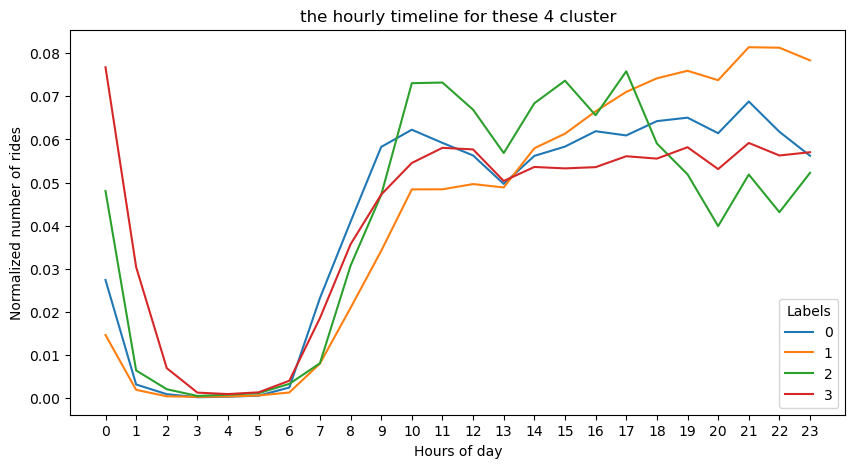

In [105]:
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

ht = TRHT.transpose()
ht.plot(figsize=(10, 5))
plt.xticks(x)
plt.xlabel('Hours of day')
plt.ylabel('Normalized number of rides')
plt.title("the hourly timeline for these 4 cluster")
plt.show()